<a href="https://colab.research.google.com/github/Sanjayan07/A2Q4MonthlyMorgagePaymenAppSP/blob/master/Copy_of_Final_Travel_Go_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

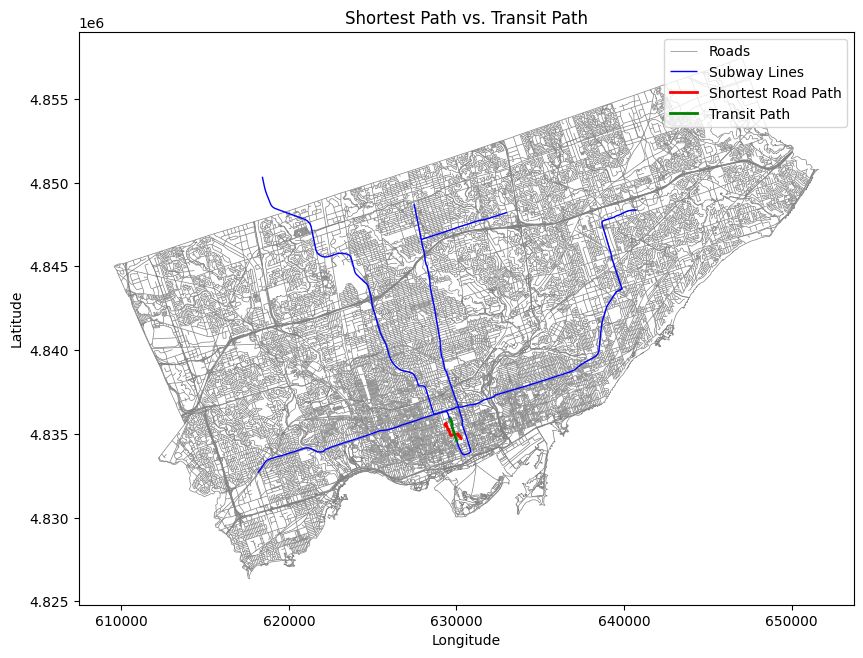

\Shortest Path Directions:
Start on 201500 from (630268.138656759, 4834717.150598425) to (630264.069950208, 4834718.446146567)
Turn left 201500 from (630264.069950208, 4834718.446146567) to (630245.2630802467, 4834773.467106436)
Continue straight 201500 from (630245.2630802467, 4834773.467106436) to (630213.7791610752, 4834868.27273108)
Turn right 201200 from (630213.7791610752, 4834868.27273108) to (630149.3418157861, 4834848.289553557)
Turn left 201200 from (630149.3418157861, 4834848.289553557) to (630123.3319782888, 4834925.131826743)
Turn right 201400 from (630123.3319782888, 4834925.131826743) to (630113.1582594675, 4834929.668245549)
Turn left 204002 from (630113.1582594675, 4834929.668245549) to (630083.4989424387, 4835017.973342937)
Turn right 201400 from (630083.4989424387, 4835017.973342937) to (629908.1224863271, 4834963.545361961)
Continue straight 201200 from (629908.1224863271, 4834963.545361961) to (629857.1206780061, 4834950.060500016)
Continue straight 201400 from (62

In [2]:
import os
import zipfile
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math


zip_path_road = "/content/Centreline - Version 2 - 4326.zip"
zip_path_subway = "/content/ttc-subway-shapefile-wgs84.zip"


#extract all data from the zipfiles
with zipfile.ZipFile(zip_path_road, 'r') as zip_ref:
    zip_ref.extractall("/content/CentreLine")
with zipfile.ZipFile(zip_path_subway, 'r') as zip_ref:
    zip_ref.extractall("/content/TTCLines")


roads = gpd.read_file("/content/CentreLine/Centreline - Version 2 - 4326.shp")
subway_lines = gpd.read_file("/content/TTCLines/TTC_SUBWAY_LINES_WGS84.shp")

street_name_column = 'NAME'


roads = roads.to_crs(epsg=32617)
subway_lines = subway_lines.to_crs(epsg=32617)

G_road = nx.Graph()
G_transit = nx.Graph()



def add_edges_from_linestring(graph, df, weight_factor=1):
    for _, row in df.iterrows():
        line = row.geometry
        if isinstance(line, LineString):
            for i in range(len(line.coords) - 1):
                start = line.coords[i]
                end = line.coords[i + 1]
                distance = Point(start).distance(Point(end)) * weight_factor
                graph.add_edge(start, end, weight=distance)

add_edges_from_linestring(G_road, roads, weight_factor=1)
add_edges_from_linestring(G_transit, subway_lines, weight_factor=0.5)




def get_nearest_node(graph, point):
    nearest_node = None
    min_distance = float('inf')
    for node in graph.nodes:
        dist = Point(node).distance(point)
        if dist < min_distance:
            nearest_node = node
            min_distance = dist
    return nearest_node




def find_shortest_path(graph, start_point, end_point):
    start_node = get_nearest_node(graph, start_point)
    end_node = get_nearest_node(graph, end_point)
    path = nx.dijkstra_path(graph, start_node, end_node, weight='weight')
    return path



def plot_paths(graph_road, graph_transit, path_road, path_transit, roads, subway_lines):
    plt.figure(figsize=(10, 10))


    roads.plot(ax=plt.gca(), color="gray", linewidth=0.5, label="Roads")
    subway_lines.plot(ax=plt.gca(), color="blue", linewidth=1, label="Subway Lines")

    path_road_coords = [Point(coord) for coord in path_road]
    road_line = LineString(path_road_coords)
    x, y = road_line.xy
    plt.plot(x, y, color="red", linewidth=2, label="Shortest Road Path")

    path_transit_coords = [Point(coord) for coord in path_transit]
    transit_line = LineString(path_transit_coords)
    x, y = transit_line.xy
    plt.plot(x, y, color="green", linewidth=2, label="Transit Path")

    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Shortest Path vs. Transit Path")
    plt.show()




def calculate_angle(p1, p2, p3):
    vector_a = (p2[0] - p1[0], p2[1] - p1[1])
    vector_b = (p3[0] - p2[0], p3[1] - p2[1])
    angle = math.atan2(vector_b[1], vector_b[0]) - math.atan2(vector_a[1], vector_a[0])
    angle = math.degrees(angle)
    if angle > 180:
        angle -= 360
    elif angle < -180:
        angle += 360
    return angle
street_name_column = 'FEATURE35'




def get_detailed_directions(graph, path, roads_df, street_name_column):
    directions = []
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]

        start_point = Point(start)
        nearest_road = roads_df.distance(start_point).idxmin()
        street_name = roads_df.iloc[nearest_road][street_name_column]

        if i > 0:
            previous = path[i - 1]
            angle = calculate_angle(previous, start, end)
            if angle > 30:
                turn_direction = "Turn right"
            elif angle < -30:
                turn_direction = "Turn left"
            else:
                turn_direction = "Continue straight"
        else:
            turn_direction = "Start on"

        directions.append(f"{turn_direction} {street_name} from {start} to {end}")

    return directions

#please assume N and E is positive and W and S are negative
start_point = Point(-79.3841, 43.6534)  #ROM
end_point = Point(-79.3957, 43.6629)    # Queen's Park
start_point_proj = gpd.GeoSeries([start_point], crs="EPSG:4326").to_crs(roads.crs).iloc[0]
end_point_proj = gpd.GeoSeries([end_point], crs="EPSG:4326").to_crs(roads.crs).iloc[0]


shortest_path_road = find_shortest_path(G_road, start_point_proj, end_point_proj)
transit_path = find_shortest_path(G_transit, start_point_proj, end_point_proj)


plot_paths(G_road, G_transit, shortest_path_road, transit_path, roads, subway_lines)

shortest_detailed_directions = get_detailed_directions(G_road, shortest_path_road, roads, street_name_column)

print("\Shortest Path Directions:")
for direction in shortest_detailed_directions:
    print(direction)